In [1]:
# Run this cell to set up packages for lecture.
from lec23_imports import *

# Lecture 23 – Correlation

## DSC 10, Spring 2025

### Agenda

- Recap: Statistical inference.
- Association.
- Correlation.
- Regression.

## Recap: Statistical inference

### What we've learned about inference

At a high level, the second half of this class has been about **statistical inference** – using a sample to draw conclusions about the population.

- To test whether a sample came from a known population distribution, use "standard" hypothesis testing. 

- To test whether two samples came from the same unknown population distribution, use permutation testing.

- To estimate a population parameter given a single sample, construct a confidence interval using bootstrapping (for most statistics) or the CLT (for the sample mean).

- To test whether a population parameter is equal to a particular value, $x$, construct a confidence interval using bootstrapping (for most statistics) or the CLT (for the sample mean), and check whether $x$ is in the interval.

### Moving forward

- For the remainder of the quarter, we'll switch our focus to **prediction** – given a sample, what can I predict about data not in that sample?

- Specifically, we'll focus on **linear regression**, a prediction technique that tries to find the best "linear relationship" between two numerical variables.

- Along the way, we'll address another idea – **correlation**.

- You will see linear regression in many more courses – it is one of the most important tools in the data science toolkit.

## Association

### Prediction

- Suppose we have a dataset with at least two numerical variables.

- We're interested in **predicting** one variable based on another:
    - Given my education level, what is my income?
    - Given my height, how tall will my kid be as an adult?
    - Given my age, how many countries have I visited?

- To do this effectively, we need to first observe a pattern between the two numerical variables.

- To see if a pattern exists, we'll need to draw a scatter plot.

### Association

- An **association** is any relationship or link 🔗 between two variables in a **scatter plot**. Associations can be linear or non-linear.

- If two variables have a positive association ↗️, then as one variable increases, the other tends to increase.

- If two variables have a negative association ↘️, then as one variable increases, the other tends to decrease.

- If two variables are associated, then we can predict the value of one variable based on the value of the other.

### Example: Hybrid cars 🚗

Our dataset, taken from [here](https://search.r-project.org/CRAN/refmans/DJL/html/dataset.hev.2013.html), contains information about several hybrid cars with model years from 1997 through 2013.

In [2]:
hybrid = bpd.read_csv('data/hybrid.csv')
hybrid

,vehicle,year,price,acceleration,mpg,class
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact
1,Tino,2000,35354.97,8.20,54.10,Compact
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact
...,...,...,...,...,...,...
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize
152,Chevrolet Volt,2013,39145.00,11.11,37.00,Compact


### `'price'` vs. `'acceleration'`

Is there an association between these two variables? If so, what kind?

(Note: When looking at a scatter plot, we often describe it in the form "$y$ vs. $x$.")

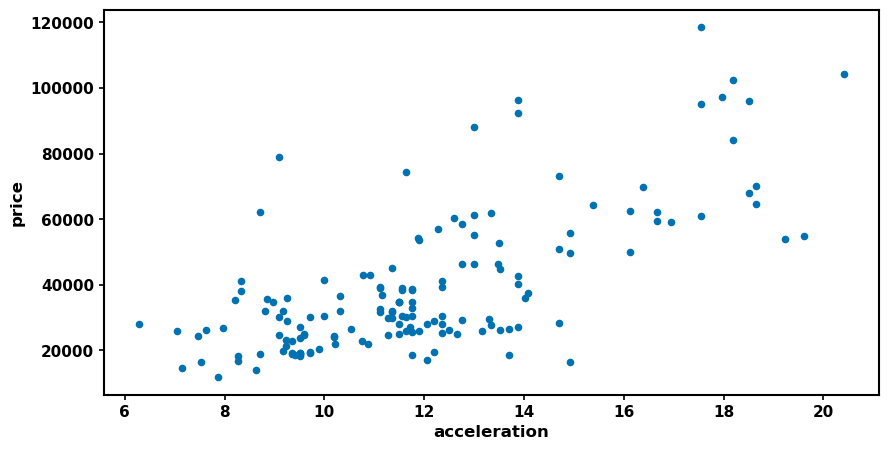

In [3]:
hybrid.plot(kind='scatter', x='acceleration', y='price');

Acceleration here is measured in kilometers per hour per second – this means that larger accelerations correspond to quicker cars!

### `'price'` vs. `'mpg'`

Is there an association between these two variables? If so, what kind?

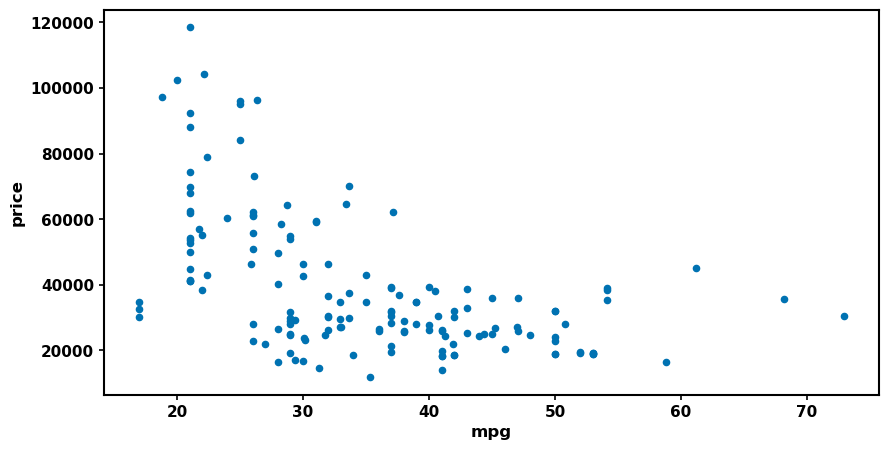

In [4]:
hybrid.plot(kind='scatter', x='mpg', y='price');

- There is a negative association – cars with better fuel economy tended to be cheaper.
    - Why do we think that's the case?
    - Is this always the case today, with the advent of expensive electric cars?

- The association looks more curved than linear. 
    - It may roughly follow $y \approx \frac{1}{x}$.   

### Exploring the data

Just for fun, we can look at an interactive version of the previous plot. Hover over a point to see the name of the corresponding car.

In [5]:
px.scatter(hybrid.to_df(), x='mpg', y='price', hover_name='vehicle')

Do you recognize any of the most expensive or most efficient cars? (If not, Google "ActiveHybrid 7i", "Panamera S", and "Prius.")

### Measuring association

- We're able to look at a scatter plot and tell, roughly, whether there's an association between two variables and whether it's positive or negative.

- Our first step when analyzing two numerical variables should **always** be to draw a scatter plot.

- With that said, we should also have a way of measuring whether there is an association between two numerical variables quantitatively – that is, using math and code.

## Correlation

### Definition: Correlation coefficient

- The correlation coefficient $r$ of two variables $x$ and $y$ measures the **strength of the linear association between $x$ and $y$.** That is, it measures how clustered points are around a straight line.

- $r$ is the: 
    - **average** value of the 
    - **product** of $x$ and $y$,
    - when both are measured in **standard units**.

- $r$ is always between -1 and 1.

- Let's look at some examples, before trying to understand where the formula comes from and learning how to interpret $r$.

### Example values of $r$

Consider the following few scatter plots.

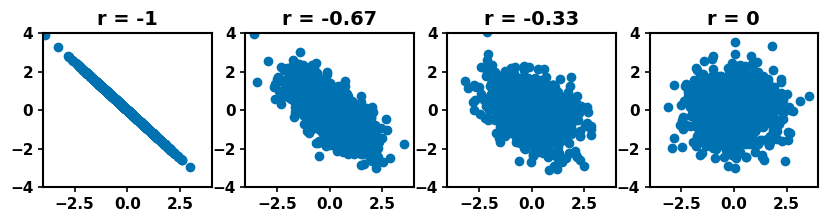

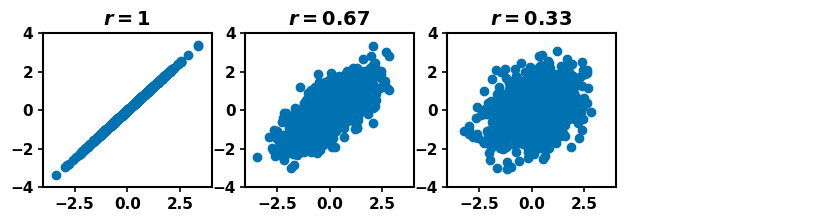

In [6]:
show_scatter_grid()

**Observation**: When $r = 1$, the scatter plot of $x$ and $y$ is a line with a positive slope, and when $r = -1$, the scatter plot of $x$ and $y$ is a line with a negative slope. When $r = 0$, the scatter plot of $x$ and $y$ is a patternless cloud of points.

To see more example scatter plots with different values of $r$, play with the widget that appears below.

In [ ]:
widgets.interact(r_scatter, r=(-1, 1, 0.05));

interactive(children=(FloatSlider(value=0.0, description='r', max=1.0, min=-1.0, step=0.05), Output()), _dom_c…

Let's now compute the value of $r$ for the two scatter plots (`'price'` vs. `'acceleration'` and `'price'` vs. `'mpg'`) we saw earlier.

### Calculating $r$

- $r$ is the average value of the product of $x$ and $y$, when both are measured in **standard units**.

- Recall: Suppose $x$ is a numerical variable, and $x_i$ is one value of that variable. To convert $x_i$ to standard units,
$$x_{i \: \text{(su)}} = \frac{x_i - \text{mean of $x$}}{\text{SD of $x$}}$$

In [8]:
def standard_units(col):
    return (col - col.mean()) / np.std(col)

Let's define a function that calculates the correlation, $r$, between two columns in a DataFrame.

In [9]:
def calculate_r(df, x, y):
    '''Returns the average value of the product of x and y, 
       when both are measured in standard units.'''
    x_su = standard_units(df.get(x))
    y_su = standard_units(df.get(y))
    return (x_su * y_su).mean()

### `'price'` vs. `'acceleration'`

Let's calculate $r$ for `'acceleration'` and `'price'`.

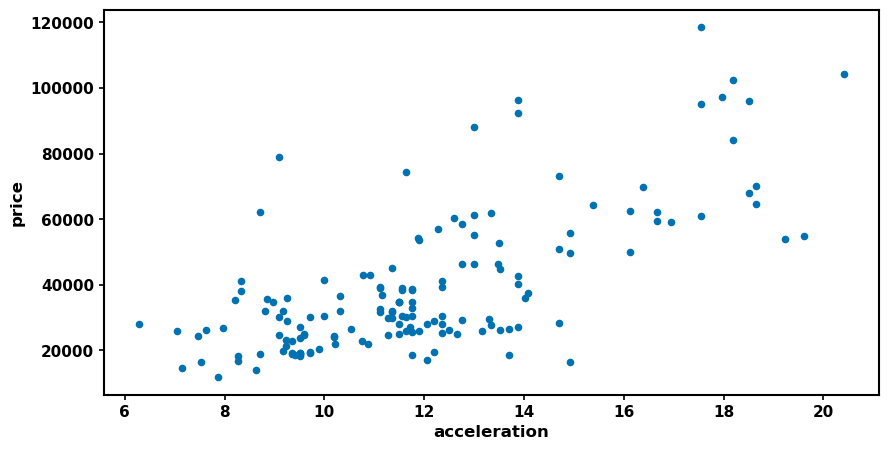

In [10]:
hybrid.plot(kind='scatter', x='acceleration', y='price');

In [11]:
calculate_r(hybrid, 'acceleration', 'price')

0.6955778996913978

**Observation**: $r$ is positive, and the association between `'acceleration'` and `'price'` is positive.

### `'price'` vs. `'mpg'`

Let's now calculate $r$ for `'mpg'` and `'price'`.

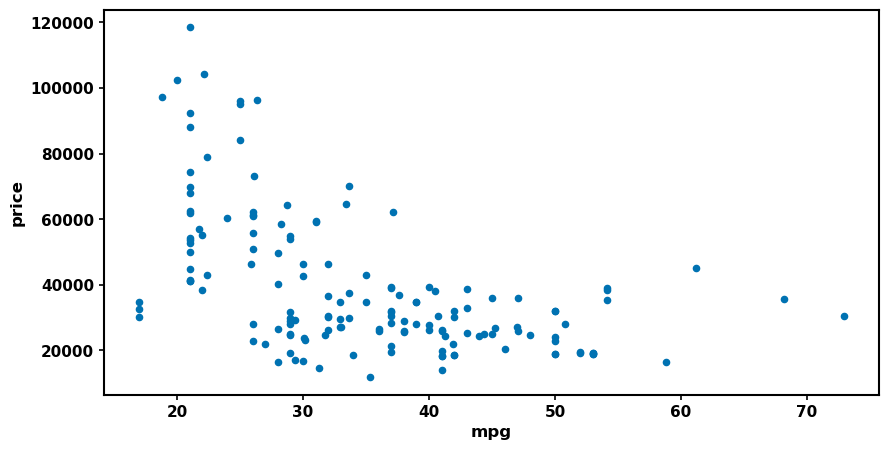

In [12]:
hybrid.plot(kind='scatter', x='mpg', y='price');

In [13]:
calculate_r(hybrid, 'mpg', 'price')

-0.5318263633683786

**Observation**: $r$ is negative, and the association between `'mpg'` and `'price'` is negative.

Also, $r$ here is closer to 0 than it was on the previous slide – that is, the **magnitude** (absolute value) of $r$ is less than in the previous scatter plot – and the points in this scatter plot look less like a straight line than they did in the previous scatter plot.

### Linear transformations

- To understand the role of standard units in the calculation of $r$, we need to discuss linear transformations.

- A **linear transformation** to a variable results from adding, subtracting, multiplying, and/or dividing each value by a constant. For example, the conversion from degrees Celsius to degrees Fahrenheit is a linear transformation:
    
    $$\text{temperature (Fahrenheit)} = \frac{9}{5} \times \text{temperature (Celsius)} + 32$$

- When you apply a linear transformation to variables in a scatter plot, all you're doing is changing the units they're measured in. **This doesn't change the shape of the plot.**
    

- In other words, instead of plotting price in _dollars_ and fuel economy in _miles per gallon_, we could plot price in _Yen (🇯🇵)_ and fuel economy in _kilometers per gallon_ and the plot would look the same, just with different axes.

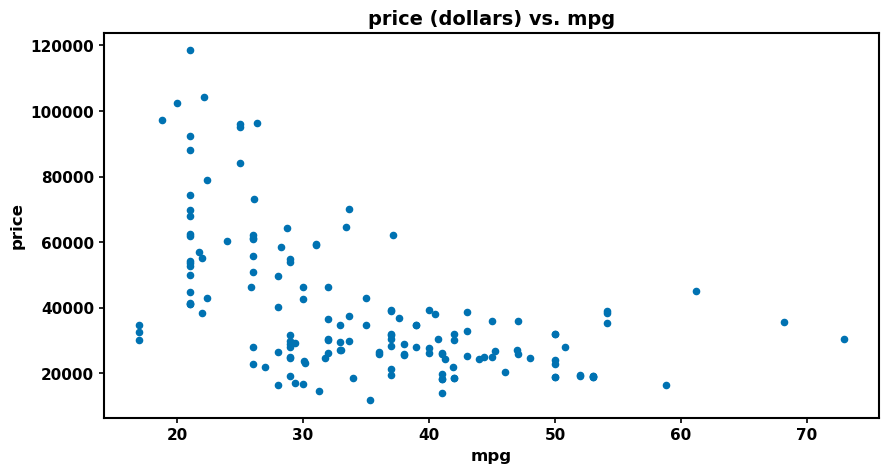

In [14]:
hybrid.plot(kind='scatter', x='mpg', y='price', title='price (dollars) vs. mpg');

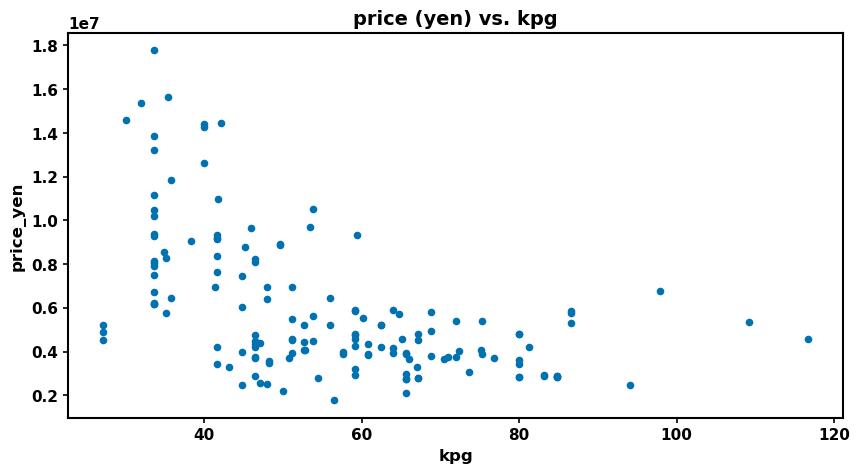

In [15]:
hybrid.assign(
    price_yen=hybrid.get('price') * 149.99, # The current USD to Japanese Yen exchange rate.
    kpg=hybrid.get('mpg') * 1.6             # 1 mile is 1.6 kilometers.
).plot(kind='scatter', x='kpg', y='price_yen', title='price (yen) vs. kpg');

### Why does the formula for $r$ involve standard units?

- The conversion of a variable to standard units is a linear transformation.

$$x_{i \: \text{(su)}} = \frac{x_i - \text{mean of $x$}}{\text{SD of $x$}}$$

- Since changing the units doesn't change the shape of the plot, it also doesn't change the strength of the linear association present in the plot – **it doesn't change how much the plot resembles a straight line**. This means it shouldn't change the value of $r$.

- By always converting both $x$ and $y$ to standard units when computing $r$, we're converting all variables to a consistent set of units, to ensure that the interpretation of $r$ doesn't depend on the specific units we happened to use.

- For instance, the correlation coefficient between price in dollars and fuel economy in miles per gallon is **the same as** the correlation coefficient between price in Yen and fuel economy in kilometers per gallon. This happens because prices and fuel economies are converted to standard units when computing $r$.

### Scatter plots in standard units

To better understand why $r$ is the **average value of the product of $x$ and $y$**, when both are measured in standard units, let's convert the `'acceleration'`, `'mpg'`, and `'price'` columns to standard units, redraw the same scatter plots we saw earlier, and explore what we can learn from the product of $x$ and $y$ in standard units.

In [16]:
def standardize(df):
    """Return a DataFrame in which all columns of df are converted to standard units."""
    df_su = bpd.DataFrame()
    for column in df.columns:
        # This uses syntax that is out of scope; don't worry about how it works.
        df_su = df_su.assign(**{column + ' (su)': standard_units(df.get(column))})
    return df_su

hybrid_su = standardize(hybrid.get(['acceleration', 'mpg', 'price']))
hybrid_su

,acceleration (su),mpg (su),price (su)
0,-1.54,0.59,-6.94e-01
1,-1.28,1.76,-1.86e-01
2,-1.36,0.95,-5.85e-01
...,...,...,...
150,-0.07,0.75,-2.98e-01
151,-0.07,0.75,-2.90e-02
152,-0.29,0.20,-8.17e-03


### `'price'` vs. `'acceleration'`

Here, `'acceleration'` and `'price'` are both measured in standard units. Note that the shape of the scatter plot is the same as before; it's just that the axes are on a different scale.

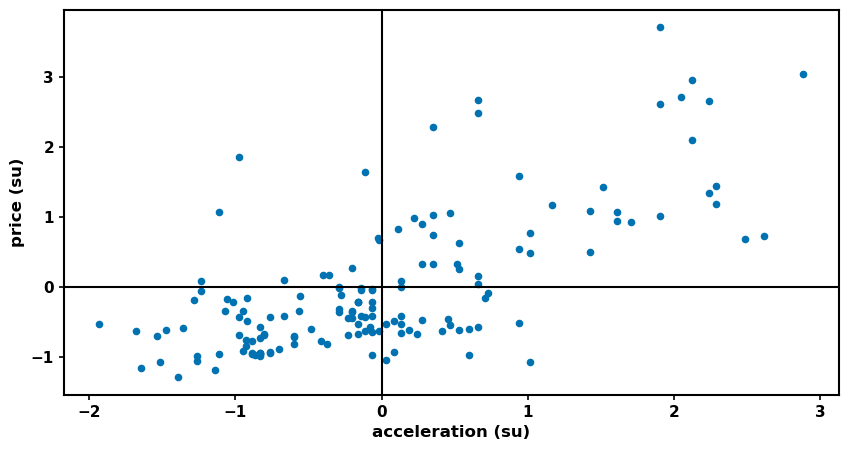

In [17]:
hybrid_su.plot(kind='scatter', x='acceleration (su)', y='price (su)')
plt.axvline(0, color='black')
plt.axhline(0, color='black');

- The association between `'acceleration'` ($x$) and `'price'` ($y$) is **positive** ↗️. Most data points fall in either the lower left quadrant (where $x_{i \: \text{(su)}}$ and $y_{i \: \text{(su)}}$ are both negative) or the upper right quadrant (where $x_{i \: \text{(su)}}$ and $y_{i \: \text{(su)}}$ are both positive).

- In other words, $x_{i \: \text{(su)}}$ and $y_{i \: \text{(su)}}$ usually have the same sign.

- On average, $x_{i \: \text{(su)}} \times y_{i \: \text{(su)}}$ should be **positive**, since when you multiply two numbers with the same sign, the result is positive.

- As a result, $r$, which is the average of $x_{i \: \text{(su)}} \times y_{i \: \text{(su)}}$, is **positive** here:

In [18]:
calculate_r(hybrid, 'acceleration', 'price')

0.6955778996913978

### `'price'` vs. `'mpg'`

Here, `'mpg'` and `'price'` are both measured in standard units. Again, note that the shape of the scatter plot is the same as before.

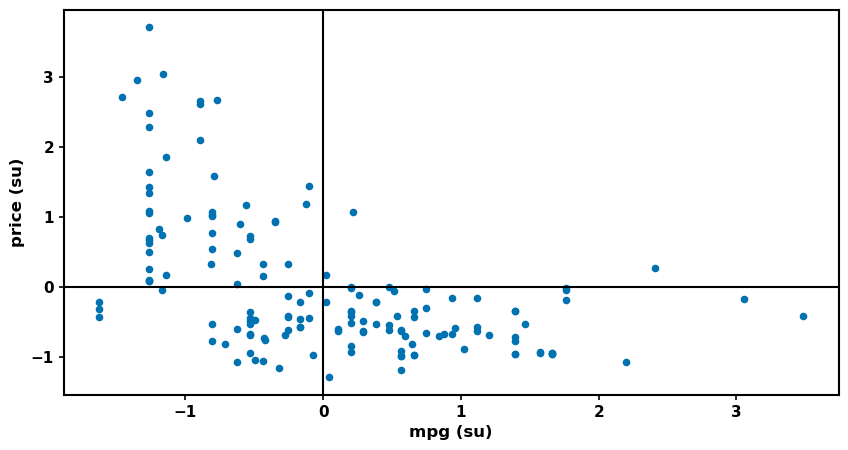

In [19]:
hybrid_su.plot(kind='scatter', x='mpg (su)', y='price (su)')
plt.axvline(0, color='black');
plt.axhline(0, color='black');

- The association between `'mpg'` ($x$) and `'price'` ($y$) is **negative** ↘️. Most data points fall in the upper left or lower right quadrants.

- In other words, $x_{i \: \text{(su)}}$ and $y_{i \: \text{(su)}}$ usually have opposite signs – for most points, one of $x_{i \: \text{(su)}}$ or $y_{i \: \text{(su)}}$ is usually positive, while the other is negative.

- On average, $x_{i \: \text{(su)}} \times y_{i \: \text{(su)}}$ should be **negative**, since when you multiply two numbers with opposite signs ($\text{positive number} \times \text{negative number}$) the result is negative.

- As a result, $r$, which is the average of $x_{i \: \text{(su)}} \times y_{i \: \text{(su)}}$, is **negative** here:

In [20]:
calculate_r(hybrid, 'mpg', 'price')

-0.5318263633683786

### Interpreting $r$

- As mentioned before, the correlation coefficient $r$ of two variables $x$ and $y$ measures the **strength of the linear association between $x$ and $y$.** That is, it measures how clustered points are around a straight line.

- **Terminology**: If two variables are correlated, it means they are linearly associated.

- $r$ is always between $-1$ and $1$.
    - If $r = 1$, the scatter plot of $x$ and $y$ is a line with a positive slope.
    - If $r = -1$, the scatter plot of $x$ and $y$ is a line with a negative slope.
    - If $r = 0$, there is no linear association between $x$ and $y$ (they are _uncorrelated_).

In [21]:
# Once again, run this cell and play with the slider that appears!
widgets.interact(r_scatter, r=(-1, 1, 0.05));

interactive(children=(FloatSlider(value=0.0, description='r', max=1.0, min=-1.0, step=0.05), Output()), _dom_c…

- $r$ is computed based on standard units, and is symmetric.
    - The correlation between price in _dollars_ and fuel economy in _miles per gallon_ is the same as the correlation between price in _Yen_ and fuel economy in _kilometers per gallon_.
    - The correlation between price and fuel economy is the same as the correlation between fuel economy and price, because $x \times y = y \times x$.

- $r$ quantifies **how well we can use a line to predict one variable from the other**.
   - If $r$ is close to $1$ or $-1$ we can predict one variable from the other quite accurately.
   - If $r$ is close to $0$, we cannot make good predictions.

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

Which of the following does the scatter plot below show?

- A. Association and correlation.
- B. Association but not correlation.
- C. Correlation but not association.
- D. Neither association nor correlation.

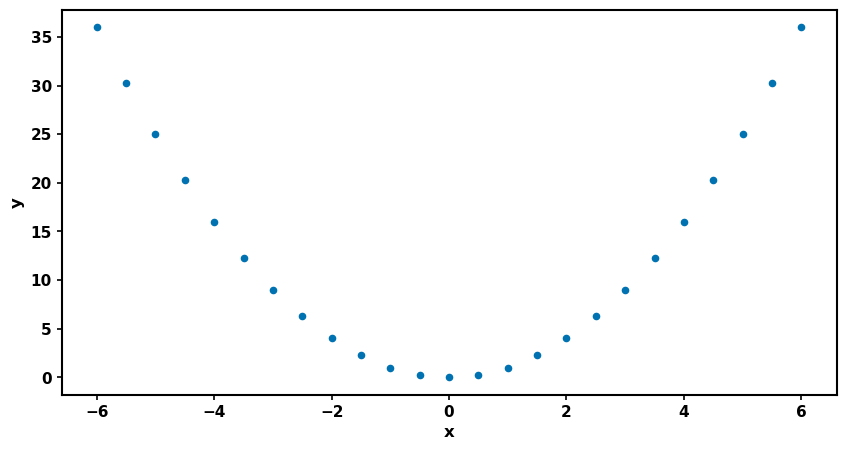

In [22]:
x2 = bpd.DataFrame().assign(
    x=np.arange(-6, 6.1, 0.5), 
    y=np.arange(-6, 6.1, 0.5) ** 2
)
x2.plot(kind='scatter', x='x', y='y');

<details><summary>✅ Click <b>here</b> to see the answer <b>after</b> trying it yourself.</summary>

B. Association but not correlation.
    
Since there is a pattern in the scatter plot of $x$ and $y$, there is an association between $x$ and $y$. However, correlation refers to <b>linear</b> association, and there is no linear association between $x$ and $y$. The relationship between $x$ and $y$ is actually $y = x^2$. Even though the association between $x$ and $y$ is very strong, the association cannot be described by a linear function because as $x$ increases, $y$ first decreases, and then increases. 
    
The correlation ($r$) between $x$ and $y$ is 0 – try to calculate it yourself!

</details>

## Regression

### Example: Predicting heights  👪 📏

The data below was collected in the late 1800s by [Francis Galton](https://en.wikipedia.org/wiki/Francis_Galton).
- He was a eugenicist and proponent of scientific racism, which is why he collected this data.
- Today, we understand that eugenics is immoral, and that there is no scientific evidence or any other justification for racism.
- Galton is credited with discovering regression using this data.

In [23]:
galton = bpd.read_csv('data/galton.csv')
galton

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,78.5,67.0,75.43,4,1,male,73.2
1,1,78.5,67.0,75.43,4,2,female,69.2
2,1,78.5,67.0,75.43,4,3,female,69.0
...,...,...,...,...,...,...,...,...
931,203,62.0,66.0,66.64,3,3,female,61.0
932,204,62.5,63.0,65.27,2,1,male,66.5
933,204,62.5,63.0,65.27,2,2,female,57.0


### Predicting an adult son's height given his mother's height

Let's focus on the relationship between mothers' heights and their adult sons' heights.

In [24]:
male_children = galton[galton.get('gender') == 'male'].reset_index()
mom_son = bpd.DataFrame().assign(mom=male_children.get('mother'), son=male_children.get('childHeight'))
mom_son

,mom,son
0,67.0,73.2
1,66.5,73.5
2,66.5,72.5
...,...,...
478,60.0,66.0
479,66.0,64.0
480,63.0,66.5


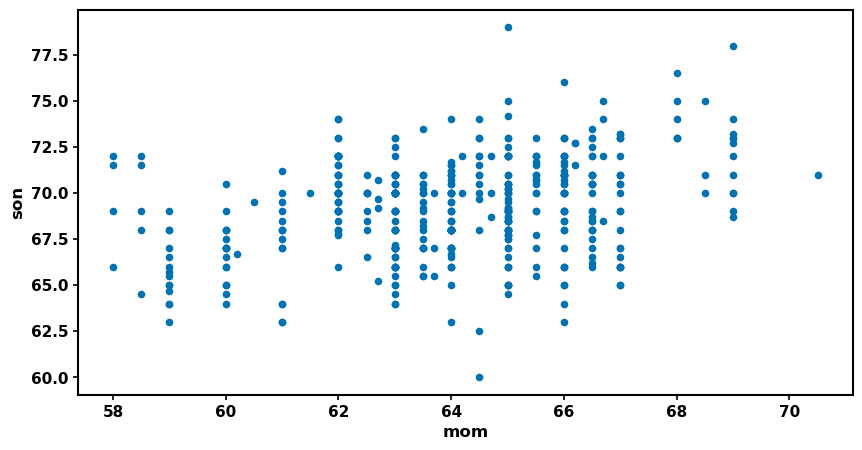

In [25]:
mom_son.plot(kind='scatter', x='mom', y='son');

The scatter plot demonstrates a positive linear association between mothers' heights and their adult sons' heights, so $r$ should be positive.

In [26]:
r_mom_son = calculate_r(mom_son, 'mom', 'son')
r_mom_son

0.3230049836849053

### Many possible ways to make predictions

- We want a _simple_ strategy, or rule, for predicting a son's height. 
- The simplest possible prediction strategy just predicts the same value for every son's height, regardless of his mother's height. 
- Some such predictions are better than others.
- Note that in the scatter plot below, both `'mom'` and `'son'` are measured in standard units, not inches.

In [27]:
mom_son_su = standardize(mom_son)

def constant_prediction(prediction):
    mom_son_su.plot(kind='scatter', x='mom (su)', y='son (su)', title=f'Predicting a height of {prediction} SUs for all sons', figsize=(10, 5));
    plt.axhline(prediction, color='orange', lw=4);
    plt.xlim(-3, 3)
    plt.show()

prediction = widgets.FloatSlider(value=-3, min=-3,max=3,step=0.5, description='prediction')
ui = widgets.HBox([prediction])
out = widgets.interactive_output(constant_prediction, {'prediction': prediction})
display(ui, out)

Output()

- Which of these predictions is the best? 
    - It depends on what we mean by "best," but a natural choice is the rule that predicts 0 standard units, because this corresponds to the mean height of all sons.

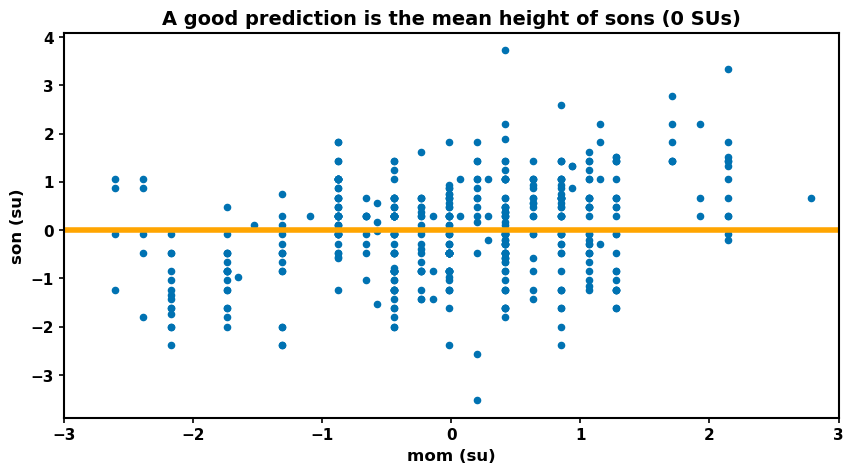

In [28]:
mom_son_su.plot(kind='scatter', x='mom (su)', y='son (su)', title='A good prediction is the mean height of sons (0 SUs)', figsize=(10, 5));
plt.axhline(0, color='orange', lw=4);
plt.xlim(-3, 3);

### Better predictions

- Since there is a linear association between a son's height and his mother's height, we can make better predictions by allowing our predictions to vary with the mother's height. 
- The simplest way to do this uses a line to make predictions.
- As before, some lines are better than others.

In [ ]:
def linear_prediction(slope):
    x = np.linspace(-3, 3)
    y = x * slope
    mom_son_su.plot(kind='scatter', x='mom (su)', y='son (su)', figsize=(10, 5));
    plt.plot(x, y, color='orange', lw=4)
    plt.xlim(-3, 3)
    plt.title(r"Predicting sons' heights using $\mathrm{son}_{\mathrm{(su)}}$ = " + str(np.round(slope, 2)) + r"$ \cdot \mathrm{mother}_{\mathrm{(su)}}$")
    plt.show()

slope = widgets.FloatSlider(value=0, min=-1,max=1,step=1/6, description='slope')
ui = widgets.HBox([slope])
out = widgets.interactive_output(linear_prediction, {'slope': slope})
display(ui, out)

Output()

- Which of these lines is the best? 
     - Again, it depends what we mean by "best," but a good choice is the line that goes through the origin and has a slope of $r$.
     - This line is called the **regression line**, and we'll see next time that it is the "best" line for making predictions in a certain sense.

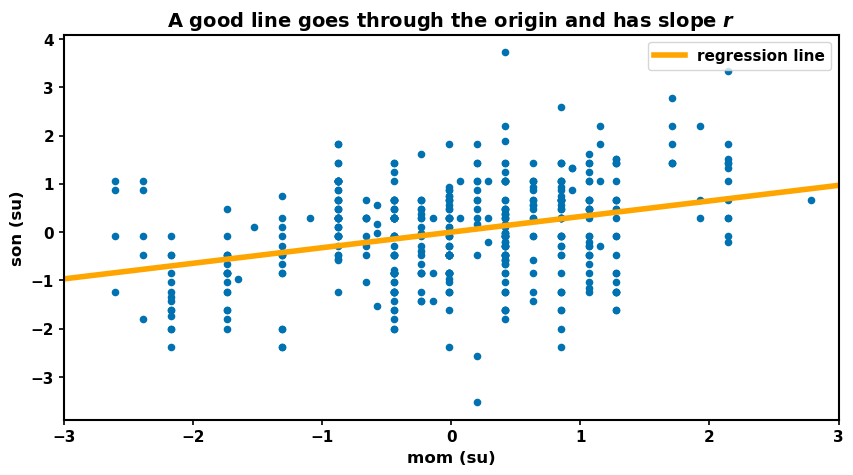

In [30]:
x = np.linspace(-3, 3)
y = x * r_mom_son
mom_son_su.plot(kind='scatter', x='mom (su)', y='son (su)', title=r'A good line goes through the origin and has slope $r$', figsize=(10, 5));
plt.plot(x, y, color='orange', label='regression line', lw=4)
plt.xlim(-3, 3)
plt.legend();

### The regression line

- The regression line is the line through $(0,0)$ with slope $r$, when both variables are measured in **standard units**.

<center><img src='images/regression-line.png' width=30%></center>

- We use the regression line to make predictions!

### Making predictions in standard units

<center><img src='images/regression-line.png' width=30%></center>

- If $r = 0.32$, and the given $x$ is $2$ in standard units, then the prediction for $y$ is $0.64$ standard units.
    - The regression line predicts that a mother whose height is $2$ SDs above average has a son whose height is $0.64$ SDs above average.

- If $r = 0.32$, and the given $x$ is $-1$ in standard units, then the prediction for $y$ is $-0.32$ standard units.

- The regression line always _predicts_ that a son will be somewhat **closer to average** in height than his mother. This effect is called **regression to the mean**, and is where the term _regression_ comes from.
    - This is a consequence of the slope $r$ having a magnitude less than 1.
    - It is not saying that a son _has to be_ closer to average in height than his mother; that's just what it predicts.

- The regression line passes through the origin $(0, 0)$ in standard units. This means that, no matter what $r$ is, **for an average $x$ value, we predict an average $y$ value**.

## Summary, next time

### Summary

- The correlation coefficient, $r$, measures the strength of the linear association between two variables $x$ and $y$. It ranges between -1 and 1.
- When both variables are measured in standard units, the regression line is the straight line passing through $(0, 0)$ with slope $r$. We can use it to make predictions for a $y$ value (e.g. son's height) given an $x$ value (e.g. mother's height).

### Next time

More on regression, including:
  - What is the equation of the regression line in original units (e.g. inches)?
  - In what sense is the regression line the "best" line for making predictions?